## This notebook provide the instructions on how to read the data from the cloud using OpenVisus framework.

###  Users will have the ability to use this Jupyter Notebook to interactively analyze and visualize parameters such as the sea-surface temperature using the LLC2160 ocean dataset [DYAMOND Visualization Data  LLC2160 ocean dataset. https://data.nas.nasa.gov/viz/vizdata/DYAMOND_c1440_llc2160/GEOS/index.html]. This notebook also allowers users to select the regions of interest. The dashboard provides the ability to directly download the data locally or to download a Python script that fetches the region from a cloud.

### To run this notebook properly, you need to install the library `OpenVisus`. To install this, please run the following command from your terminal:
`pip install OpenVisus`

# **Step 1: Importing the libraries**

In [1]:
import numpy as np
import os
os.environ["VISUS_CACHE"]="./visus_cache_can_be_erased"
from OpenVisus import *
import matplotlib.pyplot as plt
import time
start_time = time.time()

### The section below shows different LLC2160 fields we have available in cloud. Each field is >200TB.
### These datasets are stored here on the cloud via Seal Storage.



In [2]:
eastwest_ocean_velocity_u="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_arco/visus.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
northsouth_ocean_velocity_v="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_v/v_llc2160_x_y_depth.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
vertical_velocity_w="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_w/llc2160_w.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
temperature_theta="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_theta/llc2160_theta.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
Salinity_salt="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_salt/salt_llc2160_x_y_depth.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"

print ('Step 1 done: Defined variables eastwest_ocean_velocity_u, northsouth_ocean_velocity_v, vertical_velocity_w, temperature_theta, and  Salinity_salt')

In [3]:
!python --version

Python 3.11.7


## **Step 2: Reading the metadata file from cloud**
In this section, you can replace the input variable "Salinity_salt" with any of variables declared in the cells above in Step 1. 'LoadDataset' reads in the metadata for the dataset.
 

In [4]:
db=LoadDataset(Salinity_salt)
print(f'Dimensions: {db.getLogicBox()[1][0]}*{db.getLogicBox()[1][1]}*{db.getLogicBox()[1][2]}')
depth_levels = db.getLogicBox()[1][0]
longitude_levels = db.getLogicBox()[1][1]
latitude_levels  = db.getLogicBox()[1][2]

print('Take note of the dimensions, you will see them as the x and y axes on the plot')
print('')
print(f'Total Timesteps: {len(db.getTimesteps())}')

print(f'Field: {db.getField().name}')
print('Data Type: float32')
print ('Step 2 done.')

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: salt
Data Type: float32


## **Step 3:  Data Selection**
This section shows you how to load the data you want in a NumPy array. You can select any timestep, region (x,y,z) you want. You can set the quality or resolution of the data as well. Higher quality means the finer(more) data. Not setting any time means first timestep available. Not setting quality means full data which takes a while to load because of the higher filesize. 

In [5]:
# here you can select the resoution at which you query the data: -15 is very coarse, 0 is full resoltuon (dangerous since you may fetch a lot of data and wait a long time).
data_resolution = -9 # try values among -15, -12, -9, -6, -3, 0
data3D=db.read(time=0,quality=data_resolution)
print(data3D.shape)
print(np.min(data3D),np.max(data3D))
print('Step 3 done.')

(12, 810, 1080)
0.0 50.94112


## **Step 4:  Visualize the data**
We are using a simple matplotlib here, but since the data is in NumPy array, it can loaded with any python modules that support NumPy. Feel free to set the `vmin`,`vmax` appropriately.

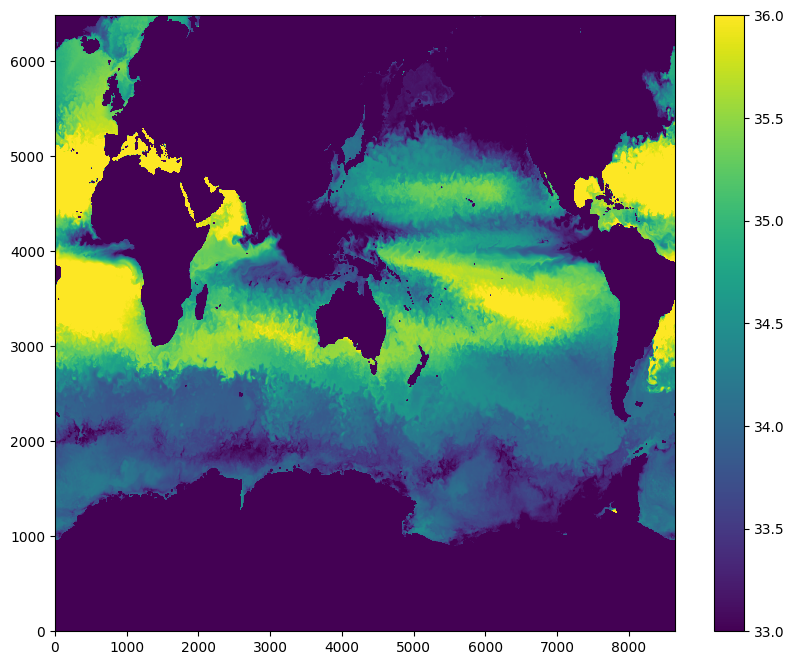

In [6]:
# Plot All the data for the field set in Step 2
depth = 0  #between 0 and 89
depth = int(depth  /db.getLogicBox()[1][2] *data3D.shape[0])
data = data3D[depth,:,:]
fig,axes=plt.subplots(1,1,figsize=(10,8))
axes.set_xlim(0,8640)
axes.set_ylim(0,6480)
axp = axes.imshow(data,extent=[0,8640,0,6480], aspect='auto',origin='lower',vmin=33,vmax=36,cmap='viridis')
plt.colorbar(axp,location='right')
plt.show()

In [7]:
#Now we can start analyzing the data.  Let's look for where the salinity is between some values and set up some variable we will use later.

min_salinity = 34
max_salinity = 35.9
#First separate land from sea by setting data_land mask to 1 when data is 0, otherwise set to 0
data_land = np.where(data == 0   , 1, 0)
#Sea is determine by setting data_sea mask to 0 (no sea) wherever data is 0, other set to 1
data_sea  = np.where(data == 0   , 0, 1)
#Find values where data is between min_salinity and max_salinity and save to data_restricted
data_restricted = np.where(data > min_salinity   , data, 0)
data_restricted = np.where(data_restricted < max_salinity  , data_restricted, 0)



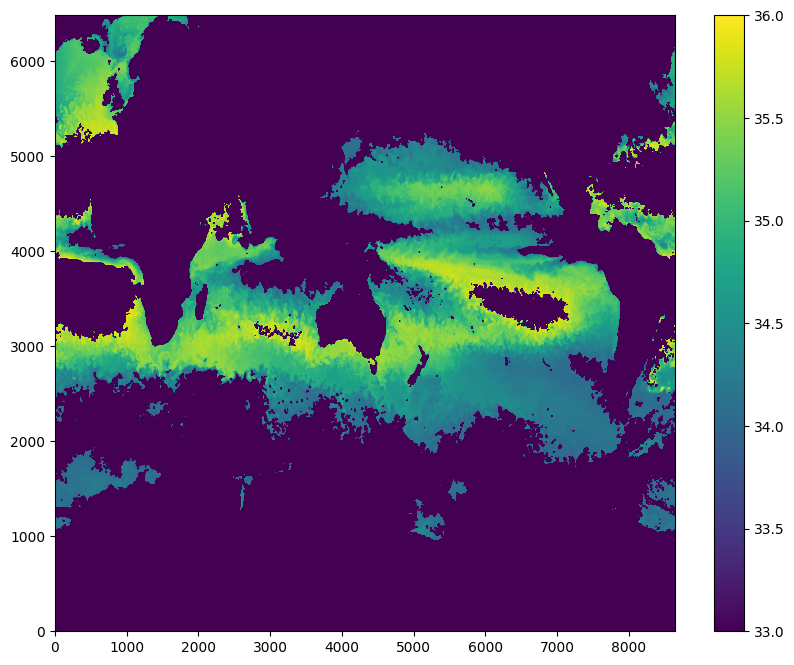

In [8]:
#Plot data_restricted (where the values of the salinity are between min_salinity and max_salinity
fig,axes=plt.subplots(1,1,figsize=(10,8))
axes.set_xlim(0,8640)
axes.set_ylim(0,6480)
axp = axes.imshow(data_restricted,extent=[0,8640,0,6480], aspect='auto',origin='lower',vmin=33,vmax=36,cmap='viridis')
plt.colorbar(axp,location='right')
plt.show()

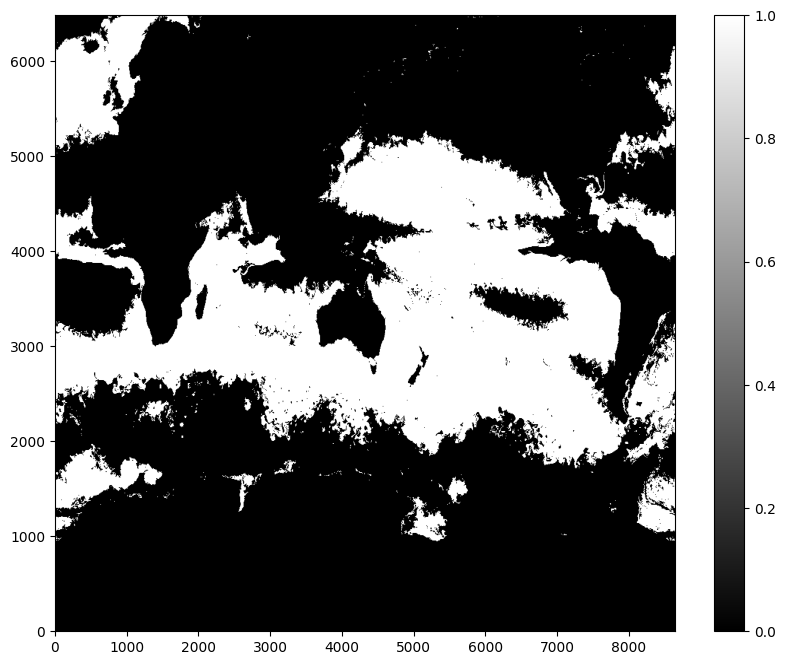

In [9]:
#Plot data_restricted as a binary image 
data_binary = np.where(data_restricted >  0  , 1 , 0)
fig,axes=plt.subplots(1,1,figsize=(10,8))
axes.set_xlim(0,8640)
axes.set_ylim(0,6480)
axp = axes.imshow(data_binary,extent=[0,8640,0,6480], aspect='auto',origin='lower',vmin=0,vmax=1,cmap='gray')
plt.colorbar(axp,location='right')
plt.show()

## **Calculate the percentage of voxels within the selected salinity range**


In [10]:
total_voxels = data.shape[0] * data.shape[1]  
land_voxels  = np.sum(data_land)
white_voxels = np.sum(data_binary)
print("Test at data resolution ", data_resolution)
print (total_voxels,land_voxels, white_voxels)
print("percentage of land voxels", '{:.2%}'.format(land_voxels/total_voxels))
print("percentage of world voxels within the salinity range", '{:.2%}'.format(white_voxels/(total_voxels)))
print("percentage of water voxels within the salinity range", '{:.2%}'.format(white_voxels/(total_voxels-land_voxels)))
end_time= time.time()
print(f'Execution time: {end_time - start_time:.2f} seconds')

Test at data resolution  -9
874800 380479 261747
percentage of land voxels 43.49%
percentage of world voxels within the salinity range 29.92%
percentage of water voxels within the salinity range 52.95%
Execution time: 1.13 seconds


## **Calculate the percentage of world surface within the selected salinity range**

In [11]:
import math
total_voxels = np.ones((data.shape[0] , data.shape[1]))  
longitude_levels = data.shape[0] 
latitude_levels  = data.shape[1] 
#longitude_levels = 11
min_longitude    = -90
max_longitude    = 75
longitude_values = np.linspace(min_longitude, max_longitude, num=longitude_levels)

world_chord_lengths = np.sin(((90- np.abs(longitude_values))/2) * np.pi / 180)

world_lenghth_mask = np.transpose(np.atleast_2d(world_chord_lengths).repeat(repeats=latitude_levels, axis=0))
#print (world_lenghth_mask)

total_surface = np.sum(total_voxels) 
land_surface  = np.sum(data_land)
sea_surface   = np.sum( data_sea)
white_surface = np.sum(data_binary)
print("----")
print(total_surface,land_surface,sea_surface, white_surface  )
print("----")

total_voxels = np.multiply(total_voxels, world_lenghth_mask)
white_voxels  = np.multiply(data_binary, world_lenghth_mask)
land_voxels  = np.multiply(data_land,  world_lenghth_mask)
sea_voxels   = np.multiply(data_sea   ,  world_lenghth_mask)

world_surface_area =  509600000 #square km

total_surface = np.sum(total_voxels) 
land_surface  = np.sum(land_voxels)
sea_surface   = np.sum ( data_sea)
white_surface = np.sum(white_voxels)
print("----")
print(total_surface,land_surface,sea_surface, white_surface  )
print("----")

print("percentage of land voxels", '{:.2%}'.format(land_surface/total_surface)," ("  '{:,}'.format(int(land_surface/total_surface*world_surface_area)),"square km)")
print("percentage of world voxels within the salinity range", '{:.2%}'.format(white_surface/(total_surface)) ," ("  '{:,}'.format(int(white_surface/total_surface*world_surface_area)),"square km)")
print("percentage of water voxels within the salinity range", '{:.2%}'.format(white_surface/(total_surface-land_surface)))


----
874800.0 380479 494321 261747
----
----
350330.355378767 106714.95416864933 494321 141260.0510085231
----
percentage of land voxels 30.46%  (155,230,455 square km)
percentage of world voxels within the salinity range 40.32%  (205,480,686 square km)
percentage of water voxels within the salinity range 57.98%


## **Summary of test Results on desktop at different resolutions**
## Note, you may want to look above and change the data resolution and see what results you get
## **Exercise for the user**: How much error is generated if you change the resolution (lower number means less data, which means more error)?

Test at data resolution  0 <br>
55987200 24342221 16750511 <br>
percentage of land voxels 43.48% <br>
percentage of world voxels within the salinity range 29.92% <br>
percentage of water voxels within the salinity range 52.93% <br>
Execution time: 1016.64 seconds <br>


Test at data resolution  -3 <br>
13996800 6086076 4187586 <br>
percentage of land voxels 43.48% <br>
percentage of world voxels within the salinity range 29.92%<br>
percentage of water voxels within the salinity range 52.94%  <br>
Execution time: 128.61 seconds (13.97 seconds with cache)<br>

Test at data resolution  -6  <br>
3499200 1521669 1046818 <br>
percentage of land voxels 43.49% <br>
percentage of world voxels within the salinity range 29.92%<br>
percentage of water voxels within the salinity range 52.94% <br>
Execution time: 16.96 seconds (3.29 seconds with cache)<br>
<br>
Test at data resolution  -15  <br>
54810 23921 16356 <br>
percentage of land voxels 43.64% <br>
percentage of world voxels within the salinity range 29.84% <br>
percentage of water voxels within the salinity range 52.95% <br>
Execution time: 1.57 seconds (1.19 seconds with cache) <br>

## **But, what if you want to see the full data for a certain region at a certain depth?**
Just set the right x,y,z while reading the data. x and y are the bounding box, z is the depth/layer. 

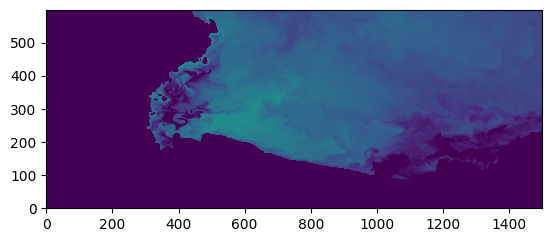

In [12]:
data1=db.read(time=0,z=[0,1],x=[4500,6000],y=[800,1400])
plt.imshow(data1[0,:,:], origin='lower',vmin=33,vmax=36,cmap='viridis')

# **Exercise for the user**: Try the same calculation on the region of interest
 
# **What calculations do you want to run on that subregion?**

### *Please reach out to Aashish Panta, Xuan Huang or Valerio Pascucci for any concerns about the notebook. Thank you!*
- Aashish Panta (aashishpanta0@gmail.com)
- Valerio Pascucci (pascucci.valerio@gmail.com)